# Network Analysis

In [1]:
import datetime
now = datetime.datetime.now()
print("Current date and time:", now.strftime("%Y-%m-%d %H:%M:%S"))

Current date and time: 2022-01-10 19:48:24


In [2]:
# Importing libraries
import yaml
import pymongo
from collections import Counter

In [3]:
# Load the Python libraries
import networkx as nx
import numpy as np

In [4]:
# Import plot libraries
import matplotlib.pyplot as plt

In [5]:
print('Networkx version:', nx.__version__)

Networkx version: 2.6.3


In [6]:
# File function - Read dict from YAML file
def get_dict_from_yaml(yaml_path:str, encoding:str="utf-8") -> dict:
    result = dict()
    
    try:
        with open(yaml_path, mode="r", encoding=encoding) as file:
            yaml_file = file.read()
            result = yaml.load(yaml_file, Loader=yaml.FullLoader)
    except Exception as e:
        print(e)
        
    return result

In [7]:
def string_to_list(str_list:str) -> list:
    if str_list == "[]":
        return []
    str_list = str_list.replace("[", "").replace("]", "").replace(" ", "").replace("\n", "")
    return str_list.split(",")

## 1. Reading data

In [8]:
# Read MongoDB login info
filepath = "config/mdb_setup.yaml"
mdb_login = get_dict_from_yaml(filepath)

In [9]:
# Create connetion to MongoDB
client  = pymongo.MongoClient(mdb_login['db_server'], mdb_login['db_port'])
db = client[mdb_login['db_name']]
coll = db[mdb_login['db_collection']]

In [10]:
# Query data
doc_list = []
for doc in coll.find({}):
    doc['claim']['nouns'] = string_to_list(doc['claim']['nouns'])
    doc['claim']['entities'] = string_to_list(doc['claim']['entities'])
    doc['majorClaim']['nouns'] = string_to_list(doc['majorClaim']['nouns'])
    doc['majorClaim']['entities'] = string_to_list(doc['majorClaim']['entities'])
    doc['premise']['nouns'] = string_to_list(doc['premise']['nouns'])
    doc['premise']['entities'] = string_to_list(doc['premise']['entities'])
    doc['syntacticTree'] = doc['syntacticTree'].replace("\r", "")
    doc_list.append(doc)

print(">> Number of annotated documents:", len(doc_list))

>> Number of annotated documents: 8650


## 2. Network analysis

### 2.1. Processing network data

In [11]:
target_proposal_id = 20389
edge_counter = Counter()

for doc in doc_list:
    if doc["proposalID"] == target_proposal_id and doc["commentID"] > -1:
        source = "c" + str(doc["parentID"]) if doc["parentID"] > -1 else "p" + str(doc["proposalID"])
        target = "c" + str(doc["commentID"])
        
        if source != target:
            edge = source + "-" + target
            edge_counter[edge] += 1

print('Total edge list:', sum(edge_counter.values()))
print(edge_counter.most_common(10))

Total edge list: 55
[('p20389-c181192', 3), ('p20389-c151201', 2), ('p20389-c180641', 2), ('c180944-c181081', 2), ('p20389-c181110', 2), ('p20389-c181115', 2), ('c181256-c181733', 2), ('p20389-c175850', 1), ('p20389-c179236', 1), ('p20389-c180625', 1)]


In [12]:
node_list = []
edge_list = []

# Add weighted edges
for key, weight in edge_counter.items():
    tokens = key.split("-")
    source = tokens[0]
    target = tokens[1]
     
    # Add nodes
    if source not in node_list:
        node_list.append(source)
    if target not in node_list:
        node_list.append(target)

    # Adde edges
    edge_list.append((source, target, weight))

### 2.2. Analyzing the network structure

In [13]:
# Create an empty Directed Weighted Graph (DWG)
dwg = nx.DiGraph()
dwg.add_nodes_from(node_list)
dwg.add_weighted_edges_from(edge_list)

In [14]:
# Function that calculates the graph density
def get_graph_density(g):
    density = -1
    n_nodes = len(g.nodes())
    n_edges = len(g.edges())
    print('n_nodes:', n_nodes, ', n_edges:', n_edges)
    
    if n_nodes > 0:
        if nx.is_directed(g):
            density = n_edges / (n_nodes * (n_nodes - 1))
        else:
            density = 2 * n_edges / (n_nodes * (n_nodes - 1))
    
    return density

In [15]:
# Calculate the graph density
density = get_graph_density(dwg)
print('graph density:', density)

n_nodes: 53 , n_edges: 47
graph density: 0.017053701015965168


#### 2.2.1. Adjacency matrix

In [16]:
# Calculate the adjacency between the nodes
adj_mtx = nx.adjacency_matrix(dwg).todense()
adj_mtx

matrix([[0, 2, 1, ..., 1, 1, 1],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]], dtype=int32)

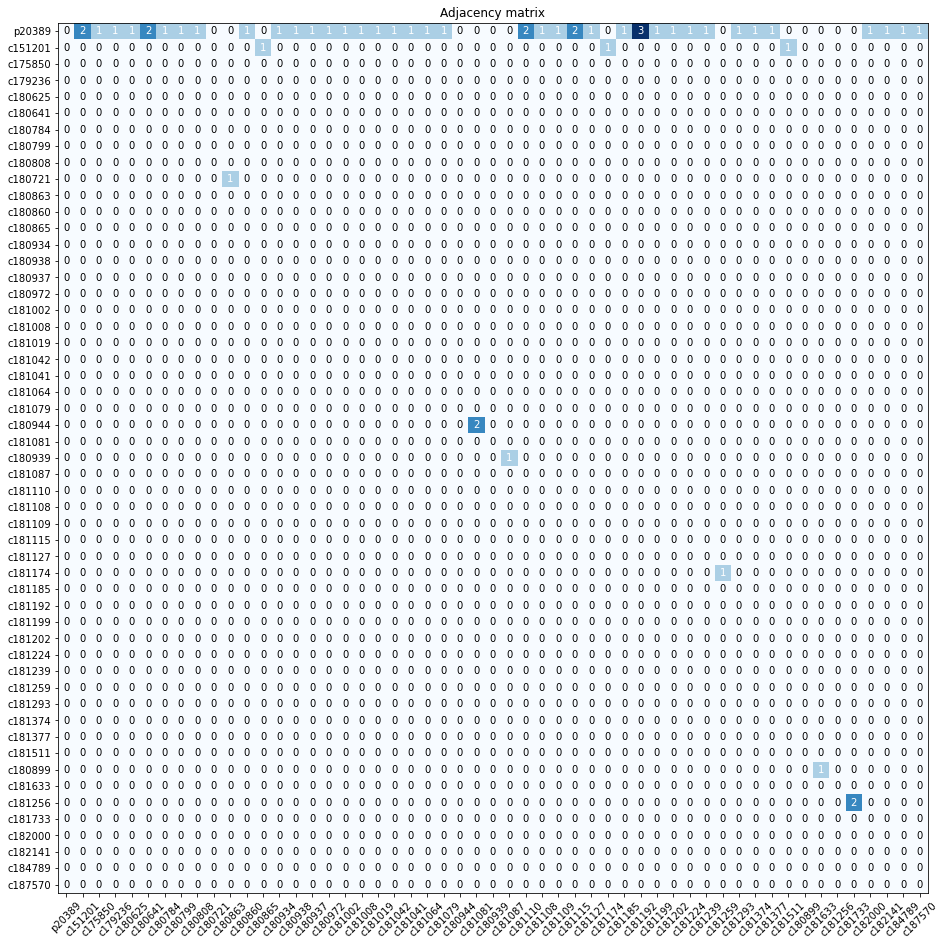

In [17]:
# Plotting the Adjacency matrix
plt.rcParams["figure.figsize"] = [16, 16]
fig, ax = plt.subplots()
ax.imshow(adj_mtx, cmap="Blues")
ax.set_xticks(np.arange(len(node_list)))
ax.set_yticks(np.arange(len(node_list)))
ax.set_xticklabels(node_list, rotation=45)
ax.set_yticklabels(node_list)

for i in range(len(node_list)):
    for j in range(len(node_list)):
        text_color = 'black' if adj_mtx[i, j] == 0 else 'white'
        text = ax.text(j, i, adj_mtx[i, j], ha="center", va="center", color=text_color)

ax.set_title("Adjacency matrix", fontsize=12)
plt.show()

#### 2.2.2. Incidence matrix

In [18]:
# Calculate the incidence of the edges on the nodes
inc_mtx = nx.incidence_matrix(dwg).todense()
inc_mtx

matrix([[1., 1., 1., ..., 0., 0., 0.],
        [1., 0., 0., ..., 0., 0., 0.],
        [0., 1., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]])

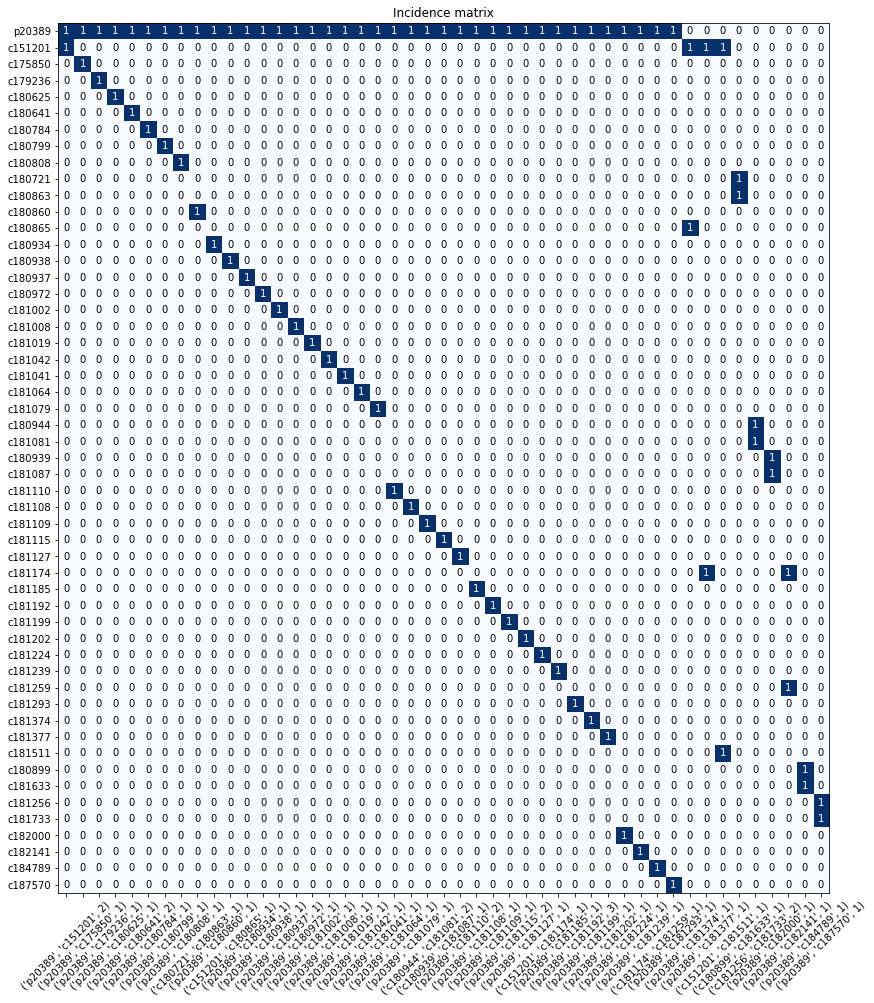

In [19]:
# Plotting the Incidence matrix
plt.rcParams["figure.figsize"] = [16, 16]
fig, ax = plt.subplots()
ax.imshow(inc_mtx, cmap="Blues")
ax.set_xticks(np.arange(len(edge_list)))
ax.set_yticks(np.arange(len(node_list)))
ax.set_xticklabels(edge_list, rotation=45)
ax.set_yticklabels(node_list)

for i in range(len(node_list)):
    for j in range(len(edge_list)):
        text_color = 'black' if inc_mtx[i, j] == 0 else 'white'
        text = ax.text(j, i, int(inc_mtx[i, j]), ha="center", va="center", color=text_color)

ax.set_title("Incidence matrix", fontsize=12)
plt.show()

#### 2.2.3. Longest path

Find the longest path in a Directed Acyclic Graph (DAG).

In [20]:
root_name = "p" + str(target_proposal_id)
root_node_ix = -1

i = 0
while i < len(node_list) and root_node_ix == -1:
    node = node_list[i]
    if node == root_name:
        root_node_ix = i
    i += 1
print("Root node ix:", root_node_ix)

Root node ix: 0


In [21]:
def get_graph_path(graph, node_ix, node_list, path):
    path_list = []
    
    node_data = [i for i, v in enumerate(graph[node_ix]) if v > 0]
    if len(node_data) == 0:
        path_list.append(path)
    else:
        for j in node_data:
            new_path = path + "-"+node_list[j]
            path_list += get_graph_path(graph, j, node_list, new_path)
    
    return path_list

path_list = get_graph_path(adj_mtx.tolist(), root_node_ix, node_list, root_name)

In [22]:
longest_paths = []
longest_path = 0

for path in path_list:
    path_size = path.count("-") + 1
    if path_size > longest_path:
        longest_path = path_size
        longest_paths = [path]
        
    elif path_size == longest_path:
        longest_paths.append(path)

print("Longest path size:", longest_path)
print(longest_paths)

Longest path size: 4
['p20389-c151201-c181174-c181259']


In [23]:
# Showing the argumentative thread (greedy approach)
for aid in longest_paths[0].split("-"):
    arg_doc = None
    for doc in doc_list:
        if ("p" in aid) and (int(aid[1:]) == doc["proposalID"]) and (doc["commentID"] == -1):
            print("> root")
            arg_doc = doc
        elif ("c" in aid) and (int(aid[1:]) == doc["commentID"]):
            print("> reply")
            arg_doc = doc
        
        if arg_doc != None:
            print("  {'claim':", doc["claim"]["text"] + "}")
            print(" ", doc["linker"])
            print("  {'premise':", doc["premise"]["text"] + "}")
            break

> root
  {'claim': Sembrar arboles nativos de la region de Madrid}
  {'linker': 'para', 'category': 'CONSEQUENCE', 'subCategory': 'GOAL', 'relationType': 'support'}
  {'premise': mejorar la calidad del aire , mantener un estilo de vida natural y mejorar la estetica urbana con seres vivos}
> reply
  {'claim': Mas de 230 arboles en tres semanas , con la excusa de que son muy peligrosos y se nos van a caer encima}
  {'linker': 'pero', 'category': 'CONTRAST', 'subCategory': 'OPPOSITION', 'relationType': 'attack'}
  {'premise': , cuando empezaron a talar , solo 4 de los 230 estaban huecos por dentro}
> reply
  {'claim': Si al menos los que talan los restituyen por otros mas jovenes}
  {'linker': 'pero', 'category': 'CONTRAST', 'subCategory': 'OPPOSITION', 'relationType': 'attack'}
  {'premise': no es asi}
> reply
  {'claim': Cuando un arbol viejo se cae sobre la gente es una catastrofe}
  {'linker': 'pero', 'category': 'CONTRAST', 'subCategory': 'OPPOSITION', 'relationType': 'attack'}
  {'p

### 2.3. Plotting Directed Weighted Graph

Argumentation network between proposals and comments.

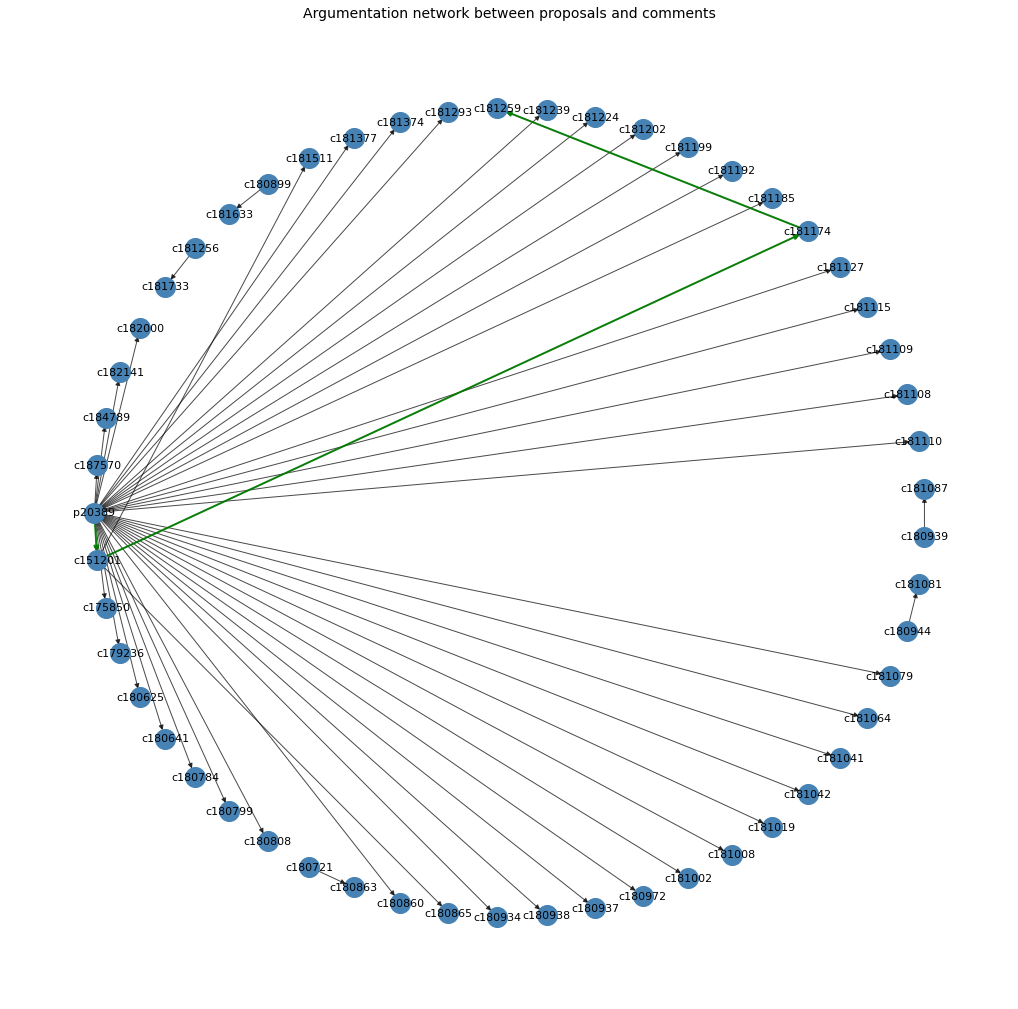

In [24]:
# Nodes labels
labels = {}
for n in dwg.nodes():
    labels[n] = n

# Edges of the longest paths
lp_edges = []
for path in longest_paths:
    nodes = path.split("-")
    for i in range(1, len(nodes)):
        lp_edges.append((nodes[i-1], nodes[i]))

# Plot Directed Weighted Graph
plt.rcParams["figure.figsize"] = [18, 18]
pos = nx.shell_layout(dwg)
nx.draw_networkx_nodes(dwg, pos, nodelist=dwg.nodes(), node_color='steelblue', node_size=400, alpha=1)
nx.draw_networkx_edges(dwg, pos, edgelist=dwg.edges(), width=1, alpha=0.7, edge_color='black')
nx.draw_networkx_edges(dwg, pos, edgelist=lp_edges, width=2, alpha=0.9, edge_color='green')
nx.draw_networkx_labels(dwg, pos, labels, font_size=11, font_color='k')
plt.title('Argumentation network between proposals and comments', fontsize=14)
plt.axis('off')
plt.show()

<hr>
<a href="https://github.com/argrecsys/arg-miner">« Back to the repository.</a>